In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arpitkumargupta","key":"bba778e802edc834f1daab046ada35e0"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kritanjalijain/amazon-reviews

Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews
License(s): CC0-1.0
 97% 1.26G/1.29G [00:08<00:00, 45.4MB/s]
100% 1.29G/1.29G [00:08<00:00, 166MB/s] 


In [5]:
!unzip amazon-reviews.zip
!ls

Archive:  amazon-reviews.zip
  inflating: amazon_review_polarity_csv.tgz  
  inflating: test.csv                
  inflating: train.csv               
amazon_review_polarity_csv.tgz	kaggle.json  test.csv
amazon-reviews.zip		sample_data  train.csv


In [6]:
import pandas as pd
train_df = pd.read_csv('train.csv',header=None,nrows=100000)

train_df.rename(columns={0:'Label',1:'Title',2:'Review'},inplace=True)
train_df=train_df.dropna()
train_df=train_df.reset_index(drop=True)
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99995 entries, 0 to 99994
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   99995 non-null  int64 
 1   Title   99995 non-null  object
 2   Review  99995 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB
None


In [7]:
positive_df=train_df[train_df['Label']==2]
negative_df=train_df[train_df['Label']==1]
print(train_df.head(100))

# # print(train_df.iloc[:1000,:][train_df['Review'].iloc[:1000].str.contains(r'\d')].head().to_string())
print(train_df['Review'].str.len().max())


#Better after tokenisation:

# l_a=[25*x for x in range(13,24)]
# lengths=[0,100,110,120,130,140,150,160]
# lengths.extend([20*x for x in range(9,16)])
# l_b=[600,630,660,700,750,800,850,900,1025]
# lengths.extend(l_a)
# lengths.extend(l_b)


# for i in range(1,35):
#     p=positive_df[(positive_df['Review'].str.len()<lengths[i])&(positive_df['Review'].str.len()>=lengths[i-1])].index.size
#     q=negative_df[(negative_df['Review'].str.len()<lengths[i])&(negative_df['Review'].str.len()>=lengths[i-1])].index.size
#     print(f"Length of sequence: {lengths[i-1]} to {lengths[i]} Number of positive reviews: {p} Number of Negative reviews: {q}, positive_class_percentage:{p/(q+p)}")


!pip  install symspellpy
!pip install pandarallel

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=4)

import inflect
import re
import unicodedata
from symspellpy.symspellpy import SymSpell, Verbosity

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

func=inflect.engine()
lemmatiser=WordNetLemmatizer()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt",0,1)

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
keep_words = {
    'not', 'no', 'never', 'nor', 'very', 'too', 'so', 'just', 'really',
    'maybe', 'perhaps', 'definitely', 'surely', 'even', 'only', 'still',
    'yet', 'most', 'more', 'less', 'least', 'better', 'worse', 'best', 'worst',
    'always', 'already', 'clearly', 'almost', 'barely', 'hardly', 'scarcely',
    'totally', 'absolutely', 'completely', 'entirely', 'strongly', 'immensely',
        'certainly','undoubtedly', 'obviously','oh', 'wow', 'ugh','aha','oops','again','good', 'bad', 'much' }

contractions_dict = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is","'d": " would","'ll": " will","'t": " not","'ve": " have", "'m": " am"}

stop_words-=keep_words

DIGIT_RE = re.compile(r'\b\d{1,10}\b')
WHITESPACE_RE = re.compile(r'\s+')
NON_WORD_RE = re.compile(r'[^\w\s!?]')

def complete_preprocessor(text):

    def correct_spelling(text):
      suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
      if suggestions:
          return suggestions[0].term
      return text

    def num_to_text(text):
        def f(match):
            txt=match.group()
            return func.number_to_words(int(txt))
        return re.sub(DIGIT_RE,f,text)

    def fix_contractions(txt):
        for x,y in contractions_dict.items():
            pattern = re.compile(r'\b' + re.escape(x) + r'\b', flags=re.IGNORECASE)
            txt = pattern.sub(y, txt)
        return txt


    def get_wordnet_tag(tb_tag):
        if tb_tag.startswith('J'):
            return 'a'
        elif tb_tag.startswith('V'):
            return 'v'
        elif tb_tag.startswith('R'):
            return 'r'
        elif tb_tag.startswith('N'):
            return 'n'
        else:
            return None # To take care of relevant punctuations

    def lemmatise(ls):
        return [lemmatiser.lemmatize(token,get_wordnet_tag(tb_tag)) if get_wordnet_tag(tb_tag) else token for token, tb_tag in ls if token not in stop_words]

    if not isinstance(text,str):
        return text
    text=text.lower().strip()
    text=re.sub(WHITESPACE_RE, ' ', text)

    text=unicodedata.normalize('NFKD', text)
    text=num_to_text(text)
    text=re.sub(NON_WORD_RE,'', text)
    text=fix_contractions(text)
    text=correct_spelling(text)

    word_tokens=word_tokenize(text)
    tags=pos_tag(word_tokens)
    return lemmatise(tags)

#Rare Words later

train_df['Title']=train_df['Title'].parallel_apply(complete_preprocessor)
train_df['Review']=train_df['Review'].parallel_apply(complete_preprocessor)

train_df=train_df[(train_df['Title'].apply(len)>0)&(train_df['Review'].apply(len)>0)]
train_df=train_df.reset_index(drop=True)
train_df['Label']-=1

    Label                                              Title  \
0       2                     Stuning even for the non-gamer   
1       2              The best soundtrack ever to anything.   
2       2                                           Amazing!   
3       2                               Excellent Soundtrack   
4       2  Remember, Pull Your Jaw Off The Floor After He...   
..    ...                                                ...   
95      1                           Very Not Worth Your Time   
96      2                           Very fun and educational   
97      1                                Ludicrous and silly   
98      2                                           Artistry   
99      1                                           Caution!   

                                               Review  
0   This sound track was beautiful! It paints the ...  
1   I'm reading a lot of reviews saying that this ...  
2   This soundtrack is my favorite music of all ti...  
3   I t

2025-06-11 07:01:40,496: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en_82_765.txt.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
!ls
!rm glove.6B.zip.1 glove.6B.zip
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls

glove_input_file = 'glove.6B.100d.txt'

from nltk.corpus import sentiwordnet
nltk.download('sentiwordnet')



amazon_review_polarity_csv.tgz	kaggle.json  test.csv
amazon-reviews.zip		sample_data  train.csv
rm: cannot remove 'glove.6B.zip.1': No such file or directory
rm: cannot remove 'glove.6B.zip': No such file or directory
--2025-06-11 07:10:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-11 07:10:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-11 07:10:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Con

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [19]:
# new_lengths=[0,100]
# new_lengths.extend([50*x for x in range(3,22)])

positive_df=train_df[train_df['Label']==2]
negative_df=train_df[train_df['Label']==1]

print(positive_df[positive_df['Review'].apply(len)==0].index.size)
print(negative_df[negative_df['Review'].apply(len)==0].index.size)
# for i in range(1,21):
#     p=positive_df[(positive_df['Review'].apply(len)<new_lengths[i])&(positive_df['Review'].apply(len)>=new_lengths[i-1])].index.size
#     q=negative_df[(negative_df['Review'].apply(len)<new_lengths[i])&(negative_df['Review'].apply(len)>=new_lengths[i-1])].index.size
#     print(f"Length of sequence: {new_lengths[i-1]} to {new_lengths[i]} Number of positive reviews: {p} Number of Negative reviews: {q}, positive_class_percentage:{p/(q+p)}")

from collections import Counter
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence

def build_vocab(df):
    counter=Counter()
    cols=['Title','Review']
    for col in cols:
        df[col].apply(lambda word_tokens: counter.update(word_tokens))
    vocab={'UNK':1,'PAD':0,'POS':2,'NEG':3}
    index=4
    for word,freq in counter.items():
        if freq>=1:
            vocab[word]=index
            index+=1
    return vocab

def int_tokens(df,vocab):

    def get_int_tokens(ls):
        return [vocab.get(token) if token in vocab else vocab.get('UNK') for token in ls]

    cols=['Title','Review']
    for col in cols:
        df[col]=df[col].apply(lambda x : get_int_tokens(x))

def seq_pad(df,pad_value=0):
    df['Title']=df['Title'].apply(lambda x: torch.tensor(x,dtype=torch.long))
    df['Review']=df['Review'].apply(lambda x: torch.tensor(x,dtype=torch.long))

    a=(torch.tensor(df['Label'].values,dtype=torch.long))
    Title_tensor = pad_sequence(df['Title'].tolist(), batch_first=True, padding_value=pad_value)
    Review_tensor = pad_sequence(df['Review'].tolist(), batch_first=True, padding_value=pad_value)
    return a,Title_tensor,Review_tensor


# indices=train_df.index
# np.random.shuffle(indices)

train_df['Label']-=1
df=train_df.head(50000).copy()
print(df[df['Label']==1].index.size)
print(train_df['Label'].describe())
Vocab=build_vocab(df)
int_tokens(df,Vocab)
print(df.info())
print(df)
label_tensor,title_tensor,review_tensor=seq_pad(df)


0
0
25536
count    99712.000000
mean         0.513298
std          0.499826
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   50000 non-null  int64 
 1   Title   50000 non-null  object
 2   Review  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
       Label                    Title  \
0          1                [4, 5, 6]   
1          1            [7, 8, 9, 10]   
2          1                     [11]   
3          1                  [12, 8]   
4          1     [13, 14, 15, 16, 17]   
...      ...                      ...   
49995      1      [89, 913, 365, 688]   
49996      0      [1309, 17170, 3485]   
49997      1           [31, 213, 468]   
49998      0  [58, 559, 89, 285, 

In [32]:
print(len(Vocab)) #Parameter count shoots up! (Ideas behind using GloVe)
print(label_tensor)
print(title_tensor)
print(review_tensor)
print(df[df['Title'].apply(len)==0])
print(df.head(100))
print(df.index.size)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import seaborn as sns


glove_embed={'UNK':1,'PAD':0}
embedding_dim=10

with open(glove_input_file,'r',encoding='utf8') as f:
  for line in f:
    parts=line.strip().split()
    word=parts[0]
    vector=np.array(parts[1:], dtype=np.float32)
    glove_embed[word] = vector


101414
tensor([1, 1, 1,  ..., 1, 0, 1])
tensor([[    4,     5,     6,  ...,     0,     0,     0],
        [    7,     8,     9,  ...,     0,     0,     0],
        [   11,     0,     0,  ...,     0,     0,     0],
        ...,
        [   31,   213,   468,  ...,     0,     0,     0],
        [   58,   559,    89,  ...,     0,     0,     0],
        [17171,  3255,     0,  ...,     0,     0,     0]])
tensor([[ 1670,  2659,   480,  ...,     0,     0,     0],
        [   90,    32,  1852,  ...,     0,     0,     0],
        [    8,   805,   127,  ...,     0,     0,     0],
        ...,
        [  796, 27829,  1402,  ...,     0,     0,     0],
        [  155,  1246, 51405,  ...,     0,     0,     0],
        [21470,   666,    76,  ...,     0,     0,     0]])
Empty DataFrame
Columns: [Label, Title, Review]
Index: []
    Label                                              Title  \
0       1                  [tensor(4), tensor(5), tensor(6)]   
1       1      [tensor(7), tensor(8), tensor(9), t

1.Better to replace numbers with notation rather than to drop them;
Ensured class imbalance as well as bucket size consistency (ensures no bias, learned stratified bucketing) and so no need for Resampling or Algorithmic manipulations to consider it , can go ahead directly with training with bucketing, with both internal shuffling as well as shuffling bucket order as well;
Using titles: Do not just concatenate title and review straight away, use attention (letting the model decide), use weighted sum concatenation of final hidden states if title and review lengths differ significantly.

2.Avoid breaking sequential dependence by using same mask for each time step (variation can be across the depth and batches); Padding tokens should be 'masked' properly if to be ignored during loss computation.

3.Embedding layers can overfit because they're often large and trained from scratch;
Applying dropout to the embedding output adds noise, forcing the model to generalize rather than memorize exact embedding vectors;
Some researchers avoid dropout directly on embeddings when using pretrained embeddings (like GloVe/BERT), but it’s common in training embeddings from scratch.



In [35]:
#                                RNN Implementation

#Add batch normalisation, handle p
class RNN_model(nn.Module):
    def __init__(self, vocab, glove_map, embed_dim, hidden_dim, output_dim, pad_idx=0, dropout=0.25):

        super(RNN_model, self).__init__()
        embedding_matrix=self.create_embedding_matrix(vocab,glove_map,embed_dim)
        self.embedding=nn.Embedding.from_pretrained(torch.tensor(embedding_matrix,dtype=torch.float),freeze=True) #Can we have only selctive learning?

        layers=[]
        l_dim=embed_dim
        for dim in hidden_dim:
           layers.append(nn.RNN(l_dim, dim, bidirectional=True, batch_first=True))
           l_dim=2*dim
        self.rnn=nn.ModuleList(layers)
        self.fc=nn.Linear(4*hidden_dim[-1], output_dim)
        self.dropout=nn.Dropout(dropout)

    def create_embedding_matrix(self,vocab, glove_map, embed_dim):
      embedding_output=np.zeros((len(vocab),embed_dim))
      for word,index in vocab.items():
        if word in glove_map:
          embedding_output[index]=glove_map[word]
        else:
          if index==1:
            embedding_output[index]=np.zeros((embed_dim,))
          elif index==2:
            embedding_output[index]=np.random.uniform(0,0.5,embed_dim)
          else:
            embedding_output[index]=np.random.uniform(-0.5,0,embed_dim)
      return embedding_output


    def forward(self, title_batch, review_batch):
        title_output=self.embedding(title_batch)
        review_output=self.embedding(review_batch)
        if self.training:
          title_output=self.dropout(title_output)
          review_output=self.dropout(review_output)

        for layer in self.rnn:
          # fw_output_hidden,bw_output_hidden=layer(input)[1]

          # output,hidden=layer(input)
          # input=torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1)

          title_output,title_hidden=layer(title_output)
          review_output,review_hidden=layer(review_output)
          # if self.training:
          #   title_output=self.dropout(title_output)
          #   review_output=self.dropout(review_output)


        fw_final_title,bw_final_title=title_hidden[-2,:,:],title_hidden[-1,:,:]
        final_title=torch.cat((fw_final_title,bw_final_title),dim=1)

        fw_final_review,bw_final_review=review_hidden[-2,:,:],review_hidden[-1,:,:]
        final_review=torch.cat((fw_final_review,bw_final_review),dim=1)

        final_hidden=torch.cat((final_title,final_review),dim=1)

        if self.training:
          final_hidden=self.dropout(final_hidden)
        logits = self.fc(final_hidden)
        return logits
        # return torch.sigmoid(logits)+1

hidden_dim=[80,32,16]

RNN=RNN_model(Vocab,glove_embed,100,hidden_dim,1)
criterion=nn.BCEWithLogitsLoss()
optimiser=optim.Adam(RNN.parameters(),lr=0.001)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RNN=RNN.to(device)
criterion=criterion.to(device)

part_label_tensor,part_title_tensor,part_review_tensor=label_tensor[:20000],title_tensor[:20000],review_tensor[:20000]

dataset=TensorDataset(part_label_tensor, part_title_tensor, part_review_tensor)
data=DataLoader(dataset,batch_size=128,shuffle=True)

from tqdm import tqdm

def Back_PropTT(RNN, data, optimiser, criterion):
  RNN.train()

  max_epochs=50
  lr_min=1e-7
  loss_progression=[]
  scheduler=ExponentialLR(optimiser,gamma=0.6)

  epoch_count=1
  while epoch_count<=max_epochs:
    epoch_loss=0
    for label_batch, title_batch, review_batch in tqdm(data):

      predicted_output=RNN(title_batch.to(device),review_batch.to(device))
      loss=criterion(predicted_output.view(-1),label_batch.float().to(device))
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      epoch_loss+=loss.item()*label_batch.shape[0]# Avoids graph build up or memory leak

    current_lr=optimiser.param_groups[0]['lr']
    print(f'current lr: {current_lr}')
    epoch_loss/=len(dataset)
    loss_progression.append(epoch_loss)
    scheduler.step()

    print(f"Epoch:{epoch_count} Loss:{epoch_loss}")
    if(current_lr<=lr_min):
      print('Very slow learning rate')
      break
    if((epoch_count>2)and(int(loss_progression[-1]*1000)>int(loss_progression[-2]*1000))):
      for param_group in optimiser.param_groups:
        param_group['lr']*=0.1

    epoch_count+=1

  return loss_progression


100%|██████████| 157/157 [00:01<00:00, 90.90it/s]


current lr: 0.001
Epoch:1 Loss:0.5271625212669373


100%|██████████| 157/157 [00:01<00:00, 96.68it/s]


current lr: 0.0006
Epoch:2 Loss:0.46945936040878294


100%|██████████| 157/157 [00:01<00:00, 93.98it/s]


current lr: 0.00035999999999999997
Epoch:3 Loss:0.45037715244293214


100%|██████████| 157/157 [00:01<00:00, 86.47it/s]


current lr: 0.00021599999999999996
Epoch:4 Loss:0.43405080547332764


100%|██████████| 157/157 [00:02<00:00, 66.25it/s]


current lr: 0.00012959999999999998
Epoch:5 Loss:0.4201415217399597


100%|██████████| 157/157 [00:02<00:00, 72.45it/s]


current lr: 7.775999999999999e-05
Epoch:6 Loss:0.411005955696106


100%|██████████| 157/157 [00:01<00:00, 94.65it/s]


current lr: 4.665599999999999e-05
Epoch:7 Loss:0.40617876539230346


100%|██████████| 157/157 [00:01<00:00, 95.34it/s]


current lr: 2.7993599999999992e-05
Epoch:8 Loss:0.4007768821716309


100%|██████████| 157/157 [00:01<00:00, 95.74it/s]


current lr: 1.6796159999999994e-05
Epoch:9 Loss:0.40081980423927305


100%|██████████| 157/157 [00:01<00:00, 92.43it/s]


current lr: 1.0077695999999996e-05
Epoch:10 Loss:0.3966447876930237


100%|██████████| 157/157 [00:01<00:00, 94.08it/s]


current lr: 6.046617599999998e-06
Epoch:11 Loss:0.39849241514205935


100%|██████████| 157/157 [00:01<00:00, 84.57it/s]


current lr: 3.6279705599999985e-07
Epoch:12 Loss:0.3963834444999695


100%|██████████| 157/157 [00:02<00:00, 65.19it/s]


current lr: 2.176782335999999e-07
Epoch:13 Loss:0.3969435359954834


100%|██████████| 157/157 [00:02<00:00, 73.73it/s]


current lr: 1.3060694015999994e-07
Epoch:14 Loss:0.396531233215332


100%|██████████| 157/157 [00:01<00:00, 95.01it/s]


current lr: 7.836416409599996e-08
Epoch:15 Loss:0.3969722351551056
Very slow learning rate


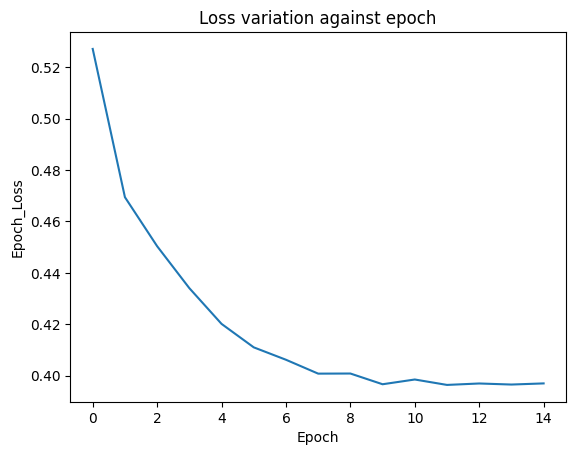

In [36]:
# What else to load on device
loss_vect=Back_PropTT(RNN, data, optimiser, criterion)
plt.plot(loss_vect)
plt.xlabel("Epoch")
plt.ylabel("Epoch_Loss")
plt.title("Loss variation against epoch")
plt.show()







In [37]:
test_df=pd.read_csv('test.csv',header=None,nrows=100000)
test_df.rename(columns={0:'Label',1:'Title',2:'Review'},inplace=True)
test_df.dropna(inplace=True)
test_df=test_df.reset_index(drop=True)

part_test_df=test_df[42000:50000].copy()
part_test_df['Title']=part_test_df['Title'].parallel_apply(complete_preprocessor)
part_test_df['Review']=part_test_df['Review'].parallel_apply(complete_preprocessor)
part_test_df['Label']-=1

part_test_df=part_test_df[(part_test_df['Title'].apply(len)>0)&(part_test_df['Review'].apply(len)>0)]
part_test_df=part_test_df.reset_index(drop=True)

int_tokens(part_test_df, Vocab)
test_label_tensor,test_title_tensor,test_review_tensor=seq_pad(part_test_df)

test_data=TensorDataset(test_label_tensor, test_title_tensor, test_review_tensor)
test_data=DataLoader(test_data,batch_size=128,shuffle=False)

Final Loss: 0.40201779174954166
Confusion Matrix: [[3324  652]
 [ 728 3271]]
PR-AUC:0.900817459050833
ROC-AUC:0.899584428300234


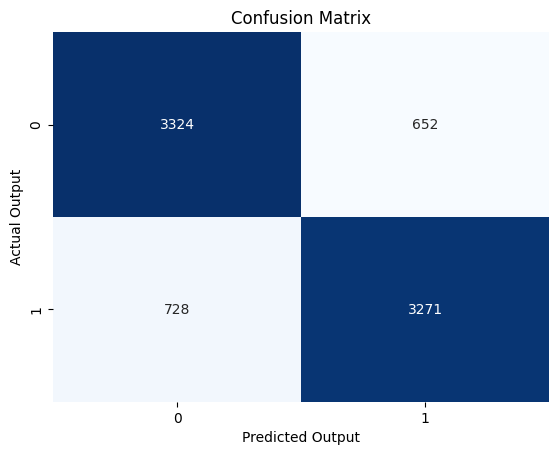

In [43]:
from sklearn.metrics import confusion_matrix,average_precision_score,roc_auc_score

RNN.eval()
with torch.no_grad():
  probs_to_gpu=[]
  predictions_to_gpu=[]
  prediction_on_test=[]
  probs=[]
  final_loss=0
  for test_label_batch, test_title_batch, test_review_batch in test_data:
    predicted_output=RNN(test_title_batch.to(device),test_review_batch.to(device))

    probs_to_gpu.append(torch.sigmoid(predicted_output).flatten())
    predictions_to_gpu.append((predicted_output>=0).int().flatten())
    prediction_on_test=torch.cat(predictions_to_gpu).cpu().numpy()
    probs=torch.cat(probs_to_gpu).cpu().numpy()

    loss=criterion(predicted_output.view(-1),test_label_batch.float().to(device))
    final_loss+=loss.item()*test_label_batch.shape[0]

  final_loss/=len(test_data.dataset)
  print(f"Final Loss: {final_loss}")

  ConfusionMatrix=confusion_matrix(test_label_tensor,prediction_on_test)
  pr_auc=average_precision_score(test_label_tensor,probs)
  roc_auc=roc_auc_score(test_label_tensor,probs)

  print(f"Confusion Matrix: {ConfusionMatrix}")
  print(f"PR-AUC:{pr_auc}")
  print(f"ROC-AUC:{roc_auc}")

  sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Output')
  plt.ylabel('Actual Output')
  plt.title('Confusion Matrix')
  plt.show()


#                   Performance-Metrics for RNN Architecture as implemented above

# Accuracy: 0.827
# Precision: 0.818
# Recall: 0.834
# F1 Score: 0.826
# PR-AUC: 0.9
# ROC-AUC: 0.899






In [58]:
#                                   LSTM Implementation

class LSTM_model(nn.Module):
  def __init__(self,vocab, global_map, embed_dim, hidden_dim, output_dim, pad_idx=0, dropout=0.25):
    super(LSTM_model,self).__init__()
    embedding_matrix=np.zeros((len(vocab),embed_dim))
    embedding_matrix=self.create_embedding_matrix(vocab,global_map,embed_dim)
    self.embedding=nn.Embedding.from_pretrained(torch.tensor(embedding_matrix,dtype=torch.float),freeze=True)

    self.lstm_layers=nn.ModuleList()
    l_dim=embed_dim
    for dim in hidden_dim:
      self.lstm_layers.append(nn.LSTM(l_dim,dim,bidirectional=True,batch_first=True))
      l_dim=2*dim

    self.fc=nn.Linear(4*hidden_dim[-1],output_dim)
    self.dropout=nn.Dropout(dropout)

  def create_embedding_matrix(self, vocab, glove_map, embed_dim):
    embedding_output=np.zeros((len(vocab),embed_dim))
    for word,index in vocab.items():
      if word in glove_map:
        embedding_output[index]=glove_map[word]
      else:
        if index==1:
          embedding_output[index]=np.zeros((embed_dim,))
        elif index==2:
          embedding_output[index]=np.random.uniform(0,0.5,embed_dim)
        else:
          embedding_output[index]=np.random.uniform(-0.5,0,embed_dim)

    return embedding_output

  def forward(self, title_batch, review_batch):
    title_output=self.embedding(title_batch)
    review_output=self.embedding(review_batch)
    if self.training:
      title_output=self.dropout(title_output)
      review_output=self.dropout(review_output)

    for layer in self.lstm_layers:
      title_output,(title_hidden,title_cell)=layer(title_output)
      review_output,(review_hidden,review_cell)=layer(review_output)

      if self.training:
        title_output=self.dropout(title_output)
        review_output=self.dropout(review_output)

    fw_final_title,bw_final_title=title_hidden[-2,:,:],title_hidden[-1,:,:]
    final_title=torch.cat((fw_final_title,bw_final_title),dim=1)
    fw_final_review,bw_final_review=review_hidden[-2,:,:],review_hidden[-1,:,:]
    final_review=torch.cat((fw_final_review,bw_final_review),dim=1)

    final_hidden=torch.cat((final_title,final_review),dim=1)
    if self.training:
      final_hidden=self.dropout(final_hidden)
    logits = self.fc(final_hidden)
    return logits


hidden_dim=[100,32,16]

LSTM=LSTM_model(Vocab, glove_embed, 100, hidden_dim, 1)
criterion=nn.BCEWithLogitsLoss()
optimiser=optim.Adam(LSTM.parameters(),lr=0.001)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LSTM=LSTM.to(device)
criterion=criterion.to(device)

part_label_tensor,part_title_tensor,part_review_tensor=label_tensor[:20000],title_tensor[:20000],review_tensor[:20000]
dataset=TensorDataset(part_label_tensor,part_title_tensor,part_review_tensor)
data=DataLoader(dataset,batch_size=128,shuffle=True)

def Back_PropTT_LSTM(LSTM, data, optimiser, criterion):

  from tqdm import tqdm
  LSTM.train()
  max_epochs_num=50
  lr_low=1e-7
  epoch_num=1
  scheduler=ExponentialLR(optimiser,gamma=0.6)
  loss_progression_list=[]

  while epoch_num<=max_epochs_num:
    epoch_loss=0

    for label_batch, title_batch, review_batch in tqdm(data):
      predicted_output=LSTM(title_batch.to(device),review_batch.to(device))
      loss=criterion(predicted_output.view(-1),label_batch.float().to(device))

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      epoch_loss+=loss.item()*label_batch.shape[0]

    epoch_loss/=len(dataset)
    loss_progression_list.append(epoch_loss)
    scheduler.step()
    print(f"Epoch:{epoch_num} Loss:{epoch_loss}")

    current_lr=optimiser.param_groups[0]['lr']
    print(f"Current lr: {current_lr}")
    if current_lr<=lr_low:
      print('Very slow learning rate')
      break

    if((epoch_num>2)and(int(loss_progression_list[-2]*1000)<int(loss_progression_list[-1]*1000))):
      for param_group in optimiser.param_groups:
        param_group['lr']*=0.1

    epoch_num+=1
  return loss_progression_list





100%|██████████| 157/157 [00:05<00:00, 27.35it/s]


Epoch:1 Loss:0.5515595502853393
Current lr: 0.0006


100%|██████████| 157/157 [00:05<00:00, 28.55it/s]


Epoch:2 Loss:0.4533332190990448
Current lr: 0.00035999999999999997


100%|██████████| 157/157 [00:05<00:00, 28.49it/s]


Epoch:3 Loss:0.42901486291885377
Current lr: 0.00021599999999999996


100%|██████████| 157/157 [00:05<00:00, 29.39it/s]


Epoch:4 Loss:0.40694807806015015
Current lr: 0.00012959999999999998


100%|██████████| 157/157 [00:05<00:00, 28.09it/s]


Epoch:5 Loss:0.39776023375988007
Current lr: 7.775999999999999e-05


100%|██████████| 157/157 [00:05<00:00, 28.89it/s]


Epoch:6 Loss:0.39374710483551023
Current lr: 4.665599999999999e-05


100%|██████████| 157/157 [00:05<00:00, 29.41it/s]


Epoch:7 Loss:0.3867272607803345
Current lr: 2.7993599999999992e-05


100%|██████████| 157/157 [00:05<00:00, 27.41it/s]


Epoch:8 Loss:0.38641542348861696
Current lr: 1.6796159999999994e-05


100%|██████████| 157/157 [00:05<00:00, 29.19it/s]


Epoch:9 Loss:0.37998854036331176
Current lr: 1.0077695999999996e-05


100%|██████████| 157/157 [00:05<00:00, 28.40it/s]


Epoch:10 Loss:0.3822008722305298
Current lr: 6.046617599999998e-06


100%|██████████| 157/157 [00:05<00:00, 27.94it/s]


Epoch:11 Loss:0.3804425236225128
Current lr: 3.6279705599999985e-07


100%|██████████| 157/157 [00:05<00:00, 29.01it/s]


Epoch:12 Loss:0.38409207401275636
Current lr: 2.176782335999999e-07


100%|██████████| 157/157 [00:05<00:00, 27.51it/s]


Epoch:13 Loss:0.3806882303237915
Current lr: 1.3060694015999994e-08
Very slow learning rate


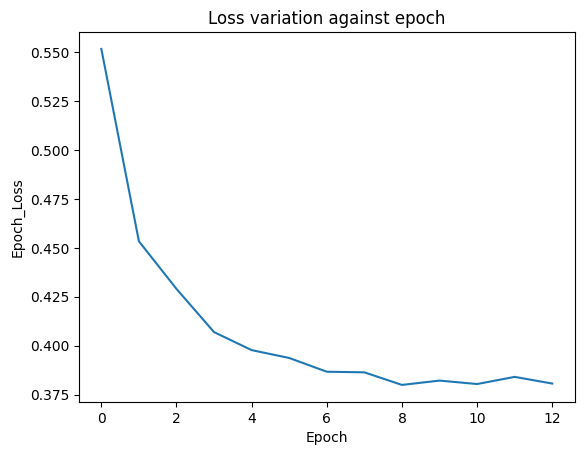

In [59]:
loss_vect=Back_PropTT_LSTM(LSTM, data, optimiser, criterion)

plt.plot(loss_vect)
plt.xlabel("Epoch")
plt.ylabel("Epoch_Loss")
plt.title("Loss variation against epoch")
plt.show()

Final Loss: 0.38310764635618205
Confusion Matrix: [[3203  773]
 [ 559 3440]]
PR-AUC:0.9132474643753536
ROC-AUC:0.9105634054388848


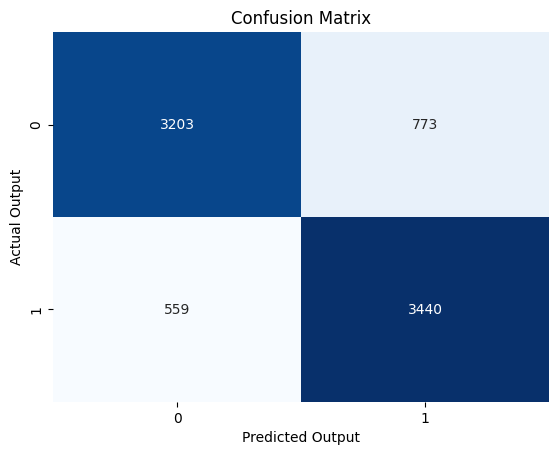

In [62]:
from sklearn.metrics import confusion_matrix,average_precision_score,roc_auc_score

LSTM.eval()
with torch.no_grad():
  LSTMprobs_to_gpu=[]
  LSTMpredictions_to_gpu=[]
  LSTM_prediction_=[]
  LSTM_probs=[]
  final_loss=0
  for test_label_batch, test_title_batch, test_review_batch in test_data:

    LSTM_output=LSTM(test_title_batch.to(device),test_review_batch.to(device))
    LSTMprobs_to_gpu.append(torch.sigmoid(LSTM_output).flatten())
    LSTMpredictions_to_gpu.append((LSTM_output>=0).int().flatten())
    LSTM_prediction=torch.cat(LSTMpredictions_to_gpu).cpu().numpy()
    LSTM_probs=torch.cat(LSTMprobs_to_gpu).cpu().numpy()

    loss=criterion(LSTM_output.view(-1),test_label_batch.float().to(device))
    final_loss+=loss.item()*test_label_batch.shape[0]

  final_loss/=len(test_data.dataset)
  print(f"Final Loss: {final_loss}")

  ConfusionMatrix=confusion_matrix(test_label_tensor,LSTM_prediction)
  pr_auc=average_precision_score(test_label_tensor,LSTM_probs)
  roc_auc=roc_auc_score(test_label_tensor,probs)

  print(f"Confusion Matrix: {ConfusionMatrix}")
  print(f"PR-AUC:{pr_auc}")
  print(f"ROC-AUC:{roc_auc}")

  sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Output')
  plt.ylabel('Actual Output')
  plt.title('Confusion Matrix')
  plt.show()



#                            Performance Metrics

# Accuracy: 0.833
# Precision: 0.860
# Recall: 0.817
# f1 Score: 0.838
# PR-AUC: 0.913
# ROC-AUC: 0.910
